In [1]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [2]:
import focusstack
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

Plotting the first photo in the example set. The millimeter ruler to the right is used as a reference for depth, and is used to annotate the image file names.

In [3]:
# video2imageFolder("images/strawberry_video/MVI_0577.MOV", "images/strawberry_video/images2")
# video2imageFolder("images/strawberry_video/MVI_0592.MOV", "images/strawberry_video/images3")

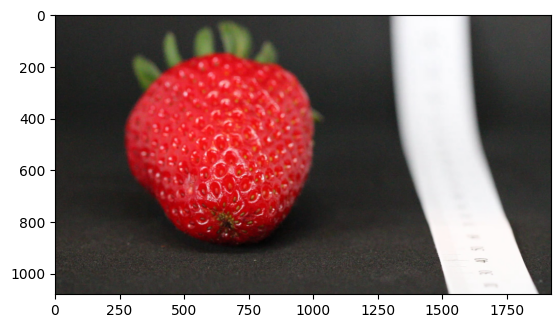

In [4]:
dir = "images/strawberry_video/images2"
# dir = "images/strawberry_video/images3"
img = "41.jpg"
# img = "f0091.jpg"
im = cv2.imread(f"{dir}/{img}")
plt.figure()
plt.imshow(im[:,:,[2,1,0]])

The images can be cropped durring processing to remove the sections of the photo with the ruler or with too much white space.

In [5]:
print(im.shape)

(1080, 1920, 3)


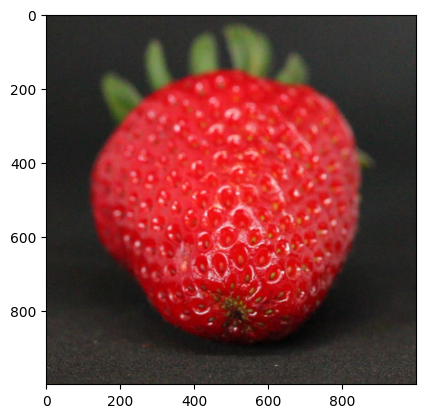

In [6]:
im_crop = im[:1000,150:1150,:]
plt.figure()
plt.imshow(im_crop[:,:,[2,1,0]])

In [7]:
print(im.shape)
print(im_crop.shape)

(1080, 1920, 3)
(1000, 1000, 3)


In [8]:
def resize_im(im, scale_percent):
    width = int(im.shape[1] * scale_percent / 100)
    height = int(im.shape[0] * scale_percent / 100)
    return cv2.resize(im, (width, height))

In [9]:
# def f_filter_white_background(im, threshold=120*3):
#     # detect white background??
#     # bright_sum = 200*3 # seems to work okay on back wall of photo box, but the "floor" in the scene is not well-lit enough.
#     # bright_sum = 110*3
#     H,W,_ = im.shape
#     for h in range(H):
#         for w in range(W):
#             if im[h,w,:].sum() > threshold:
#                 im[h,w,:] = [0,0,0]
#
#     return im

In [10]:
# def f_filter_black_background(im, threshold=10*3):
#     # detect white background??
#     # bright_sum = 200*3 # seems to work okay on back wall of photo box, but the "floor" in the scene is not well-lit enough.
#     # bright_sum = 110*3
#     H,W,_ = im.shape
#     for h in range(H):
#         for w in range(W):
#             if im[h,w,:].sum() < threshold:
#                 im[h,w,:] = [0,0,0]
#
#     return im

In [11]:
def subtract_background(im):
    fgbg = cv2.createBackgroundSubtractorMOG2()
    fgmask = fgbg.apply(im)
    return fgmask

In [12]:
def runner(dir, crop=None, resize=None, filter_white_background=False, filter_black_background=False):
    image_files = sorted(os.listdir(dir))
    for img in image_files:
        if img.split(".")[-1].lower() not in ["jpg", "jpeg", "png"]:
            image_files.remove(img)

    focusimages = []
    for img in image_files:
        print("Reading in file {}".format(img))
        focusimages.append(cv2.imread(f"{dir}/{img}"))

    for i in range(len(focusimages)):
        im = focusimages[i]
        if crop:
            im = im[crop[0]:crop[1],crop[2]:crop[3],:]
        if resize:
            im = resize_im(im, resize)
        # if filter_white_background:
        #     im = f_filter_white_background(im)
        # if filter_black_background:
        #     im = f_filter_black_background(im)
        focusimages[i] = im

    merged, mask = focusstack.focus_stack(focusimages)
    return merged, mask

Without resize, result has weird geometric artifacts that look like glass shattering from a source point in the photo.
At 75% size, there is a little bit of haziness/halo/echo stuff. At 25% and 50% the results look okay.

In [13]:
# resize = 25
resize = 50
# resize = 75
# resize = None
# crop = [0,1080,120,1200]
crop = [0,1000,150,1150]
# dir = "images/strawberry_video/images3"
dir = "images/strawberry_video/images2"
merged, mask = runner(dir, crop=crop, resize=resize)
# merged, mask = runner(dir, crop=crop, resize=resize, filter_black_background=True)

Reading in file 41.jpg
Reading in file 42.jpg
Reading in file 43.jpg
Reading in file 44.jpg
Reading in file 45.jpg
Reading in file 46.jpg
Reading in file 47.jpg
Reading in file 48.jpg
Reading in file 49.jpg
Reading in file 50.jpg
Reading in file 51.jpg
Reading in file 52.jpg
Reading in file 53.jpg
Reading in file 54.jpg
Reading in file 55.jpg
Reading in file 56.jpg
Reading in file 57.jpg
Reading in file 58.jpg
Reading in file 60.jpg
Reading in file 61.jpg
Reading in file 63.jpg
Reading in file 65.jpg
Reading in file 66.jpg
Reading in file 67.jpg
Reading in file 68.jpg
Reading in file 69.jpg
Reading in file 70.jpg
Reading in file 71.jpg
Reading in file 72.jpg
Reading in file 73.jpg
Reading in file 74.jpg
Reading in file 76.jpg
Reading in file 77.jpg
Reading in file 78.jpg
Reading in file 79.jpg
Reading in file 81.jpg
Reading in file 83.jpg
Reading in file 86.jpg
Reading in file 87.jpg
Reading in file 89.jpg
Reading in file 90.jpg
Reading in file 91.jpg
Reading in file 93.jpg
Reading in 

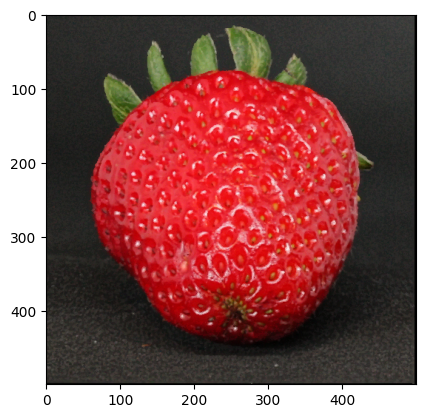

In [14]:
plt.figure()
plt.imshow(merged[:,:,[2,1,0]])

In [15]:
print(mask.shape[0])

44


In [16]:
cv2.imwrite("strawberry_merged_black_background.png", merged)

True

In [21]:
# furthest image is baseline and should have a depth of 0
# other images estimated from base image

# if images are in original filenames:
files = sorted(os.listdir(dir))
# num_frames = len(files)

reference_distances = [ int(i.split('.')[0]) for i in files]
list_max = max(reference_distances)
reference_distances = [ list_max - i for i in reference_distances]
print(reference_distances)
estimated_distances = np.interp(reference_distances, (min(reference_distances), max(reference_distances)), (0, +255))
estimated_distances = estimated_distances.astype(int)
print(estimated_distances)
# estimated_distances = [ num_frames-i for i in range(num_frames) ]
# print(estimated_distances)
# estimated_distances = np.interp(estimated_distances, (min(estimated_distances), max(estimated_distances)), (0, +255))
# estimated_distances = estimated_distances.astype(int)
# print(estimated_distances)

#TODO: is any additional scaling required? play around here, since we are not calculating with focal length like the paper

[54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 35, 34, 32, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 19, 18, 17, 16, 14, 12, 9, 8, 6, 5, 4, 2, 0]
[255 250 245 240 236 231 226 221 217 212 207 203 198 193 188 184 179 174
 165 160 151 141 136 132 127 122 118 113 108 103  99  89  85  80  75  66
  56  42  37  28  23  18   9   0]


In [22]:
print(merged.shape)

(500, 500, 3)


This is the depth map with one layer added.


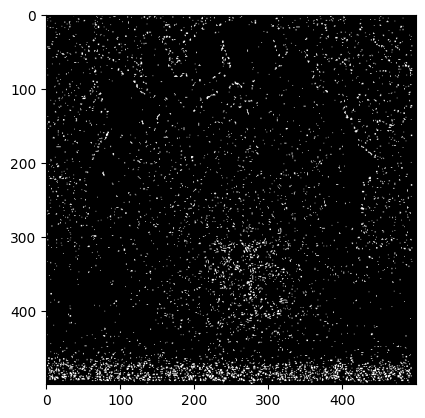

In [23]:
(H, W, _) = merged.shape
depth_map = np.zeros((H, W), dtype=np.uint8)
depth_map[mask[0]==True] = estimated_distances[0]

plt.figure()
plt.imshow(depth_map, cmap="gray")

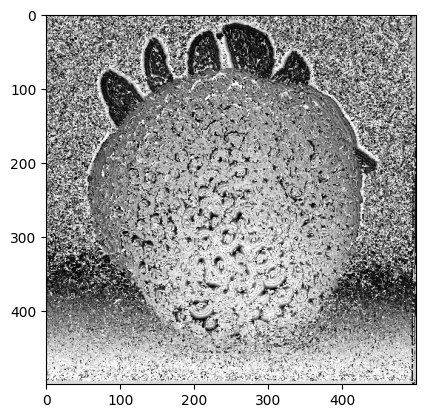

In [24]:
(H, W, _) = merged.shape
depth_map = np.zeros((H, W), dtype=np.uint8)
for i in range(mask.shape[0]):
    depth_map[mask[i]==True] = estimated_distances[i]

plt.figure()
plt.imshow(depth_map, cmap="gray")

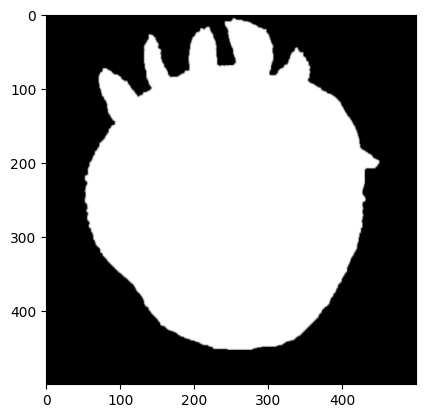

In [25]:
# TODO: could generate the mask using graph-cuts or similar? for now made it manually in Paint

mask_file = "strawberry_merged_black_background_mask.png"
mask = cv2.imread(mask_file)
plt.figure()
plt.imshow(mask, cmap="gray")

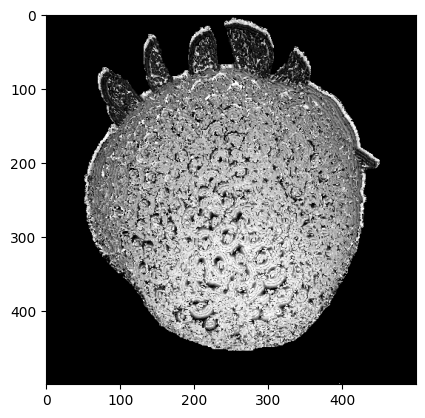

In [26]:
gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
# mask[mask>0] = 255
masked_depth_map = cv2.bitwise_and(depth_map, depth_map, mask=gray_mask)
plt.figure()
plt.imshow(masked_depth_map, cmap="gray")

In [27]:
cv2.imwrite("strawberry_black_background_masked_depth_map.png", masked_depth_map)

True